In [12]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
# Read data and merge
df = pd.read_csv('application_train.csv')
test_df = pd.read_csv('application_test.csv')
print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
df = df.append(test_df).reset_index()
# Optional: Remove 4 applications with XNA CODE_GENDER (train set)
df = df[df['CODE_GENDER'] != 'XNA']
    
docs = [_f for _f in df.columns if 'FLAG_DOC' in _f]
live = [_f for _f in df.columns if ('FLAG_' in _f) & ('FLAG_DOC' not in _f) & ('_FLAG_' not in _f)]
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

inc_by_org = df[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']

df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
df['NEW_CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
df['NEW_DOC_IND_AVG'] = df[docs].mean(axis=1)
df['NEW_DOC_IND_STD'] = df[docs].std(axis=1)
df['NEW_DOC_IND_KURT'] = df[docs].kurtosis(axis=1)
df['NEW_LIVE_IND_SUM'] = df[live].sum(axis=1)
df['NEW_LIVE_IND_STD'] = df[live].std(axis=1)
df['NEW_LIVE_IND_KURT'] = df[live].kurtosis(axis=1)
df['NEW_INC_PER_CHLD'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
df['NEW_INC_BY_ORG'] = df['ORGANIZATION_TYPE'].map(inc_by_org)
df['NEW_EMPLOY_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['NEW_ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / (1 + df['AMT_INCOME_TOTAL'])
df['NEW_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
df['NEW_EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
df['NEW_SCORES_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
df['NEW_SCORES_STD'] = df['NEW_SCORES_STD'].fillna(df['NEW_SCORES_STD'].mean())
df['NEW_CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
df['NEW_CAR_TO_EMPLOY_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
df['NEW_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
df['NEW_PHONE_TO_EMPLOY_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']
df['NEW_CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    
    # Categorical features with Binary encode (0 or 1; two categories)
for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
df, cat_cols = one_hot_encoder(df, nan_as_category=False)
    
del test_df
gc.collect()


# Preprocess bureau.csv and bureau_balance.csv
bureau = pd.read_csv('bureau.csv')
bb = pd.read_csv('bureau_balance.csv')
bb, bb_cat = one_hot_encoder(bb, nan_as_category=True)
bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category=True)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
for col in bb_cat:
    bb_aggregations[col] = ['mean']
bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
del bb, bb_agg
gc.collect()
    
    # Bureau and bureau_balance numeric features
num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
cat_aggregations = {}
for cat in bureau_cat: cat_aggregations[cat] = ['mean']
for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
bureau_agg = bureau.groupby('SK_ID_CURR').agg(dict(num_aggregations, **cat_aggregations))
bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
cols = active_agg.columns.tolist()
active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
active_agg = active_agg.reset_index() # added
bureau_agg = bureau_agg.reset_index() # added
bureau_agg = bureau_agg.merge(active_agg, how='left', on='SK_ID_CURR')
del active, active_agg
gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
closed_agg = closed_agg.reset_index() # added
bureau_agg = bureau_agg.merge(closed_agg, how='left', on='SK_ID_CURR')
    
for e in cols:
    bureau_agg['NEW_RATIO_BURO_' + e[0] + "_" + e[1].upper()] = bureau_agg['ACTIVE_' + e[0] + "_" + e[1].upper()] / bureau_agg['CLOSED_' + e[0] + "_" + e[1].upper()]
    
del closed, closed_agg, bureau
gc.collect()


# Preprocess previous_applications.csv
prev = pd.read_csv('previous_application.csv')
prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ['mean']
    
prev_agg = prev.groupby('SK_ID_CURR').agg(dict(num_aggregations, **cat_aggregations))
prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
cols = approved_agg.columns.tolist()
approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
approved_agg = approved_agg.reset_index() # added
prev_agg = prev_agg.reset_index() # added
prev_agg = prev_agg.merge(approved_agg, how='left', on='SK_ID_CURR') # Change join to merge
    # Previous Applications: Refused Applications - only numerical features
refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
refused_agg = refused_agg.reset_index() # added
prev_agg = prev_agg.merge(refused_agg, how='left', on='SK_ID_CURR') # Change join to merge
del refused, refused_agg, approved, approved_agg, prev
    
for e in cols:
    prev_agg['NEW_RATIO_PREV_' + e[0] + "_" + e[1].upper()] = prev_agg['APPROVED_' + e[0] + "_" + e[1].upper()] / prev_agg['REFUSED_' + e[0] + "_" + e[1].upper()]
    
gc.collect()


# Preprocess POS_CASH_balance.csv
pos = pd.read_csv('POS_CASH_balance.csv')
pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
for cat in cat_cols:
    aggregations[cat] = ['mean']
    
pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
del pos
gc.collect()

    
# Preprocess installments_payments.csv
ins = pd.read_csv('installments_payments.csv')
ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
for cat in cat_cols:
    aggregations[cat] = ['mean']
ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
del ins
gc.collect()


# Preprocess credit_card_balance.csv
cc = pd.read_csv('credit_card_balance.csv')
cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
del cc
gc.collect()

Train samples: 307511, test samples: 48744


231

In [ ]:
print (df.shape)
print (bureau_agg.shape)
print (prev_agg.shape)
print (pos_agg.shape)
print (ins_agg.shape)
print (cc_agg.shape)

In [13]:
# join dataset
#bureau and bureau_balance
df = df.merge(bureau_agg, how='left', on='SK_ID_CURR') 
del bureau_agg
gc.collect()
#previous_applications
df = df.merge(prev_agg, how='left', on='SK_ID_CURR')
del prev_agg
gc.collect()
#POS-CASH balance"
df = df.merge(pos_agg.reset_index(), how='left', on='SK_ID_CURR')
del pos_agg
gc.collect()
#installments payments
df = df.merge(ins_agg.reset_index(), how='left', on='SK_ID_CURR')
del ins_agg
gc.collect()
#credit card balance
df = df.merge(cc_agg.reset_index(), how='left', on='SK_ID_CURR')
del cc_agg
gc.collect()
print (df.shape)
#df.to_csv('df.csv', index=False)

(356251, 870)


In [15]:
df.columns

Index([u'index', u'AMT_ANNUITY', u'AMT_CREDIT', u'AMT_GOODS_PRICE',
       u'AMT_INCOME_TOTAL', u'AMT_REQ_CREDIT_BUREAU_DAY',
       u'AMT_REQ_CREDIT_BUREAU_HOUR', u'AMT_REQ_CREDIT_BUREAU_MON',
       u'AMT_REQ_CREDIT_BUREAU_QRT', u'AMT_REQ_CREDIT_BUREAU_WEEK',
       ...
       u'CC_NAME_CONTRACT_STATUS_Signed_MAX',
       u'CC_NAME_CONTRACT_STATUS_Signed_MEAN',
       u'CC_NAME_CONTRACT_STATUS_Signed_SUM',
       u'CC_NAME_CONTRACT_STATUS_Signed_VAR',
       u'CC_NAME_CONTRACT_STATUS_nan_MIN', u'CC_NAME_CONTRACT_STATUS_nan_MAX',
       u'CC_NAME_CONTRACT_STATUS_nan_MEAN', u'CC_NAME_CONTRACT_STATUS_nan_SUM',
       u'CC_NAME_CONTRACT_STATUS_nan_VAR', u'CC_COUNT'],
      dtype='object', length=870)

In [2]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [35]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
    # Divide in training/validation and test data
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
del df
gc.collect()
    # Cross validation model
folds = KFold(n_splits= 5, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
    dtrain = lgb.Dataset(data=train_df[feats].iloc[train_idx], 
                             label=train_df['TARGET'].iloc[train_idx], 
                             free_raw_data=False, silent=True)
    dvalid = lgb.Dataset(data=train_df[feats].iloc[valid_idx], 
                             label=train_df['TARGET'].iloc[valid_idx], 
                             free_raw_data=False, silent=True)

        # LightGBM parameters found by Bayesian optimization
    params = {
            'objective': 'binary',
            'boosting_type': 'gbdt',
            'nthread': 4,
            'learning_rate': 0.02,  
            'num_leaves': 20,
            'colsample_bytree': 0.9497036,
            'subsample': 0.8715623,
            'subsample_freq': 1,
            'max_depth': 8,
            'reg_alpha': 0.041545473,
            'reg_lambda': 0.0735294,
            'min_split_gain': 0.0222415,
            'min_child_weight': 39.3259775, # 60,
            'seed': 0,
            'verbose': -1,
            'metric': 'auc',
            #'scale_pos_weight':99.7, # because training data is extremely unbalanced 
        }
        
    clf = lgb.train(
            params=params,
            train_set=dtrain,
            num_boost_round=10000,
            valid_sets=[dtrain, dvalid],
            early_stopping_rounds=200,
            verbose_eval=False
        )

    oof_preds[valid_idx] = clf.predict(dvalid.data)
    sub_preds += clf.predict(test_df[feats]) / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(dvalid.label, oof_preds[valid_idx])))
    del clf, dtrain, dvalid
    gc.collect()

print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
sub_df = test_df[['SK_ID_CURR']].copy()
sub_df['TARGET'] = sub_preds
sub_df[['SK_ID_CURR', 'TARGET']].to_csv('submission_full_feature.csv', index= False)


Starting LightGBM. Train shape: (307507, 870), test shape: (48744, 870)
Fold  1 AUC : 0.784303
Fold  2 AUC : 0.780644
Fold  3 AUC : 0.783794
Fold  4 AUC : 0.781995
Fold  5 AUC : 0.787130
Full AUC score 0.783476


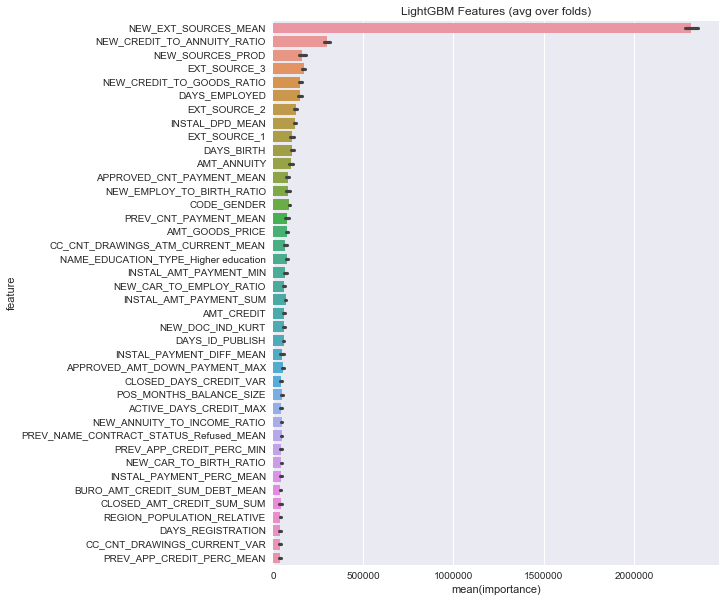

In [36]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout
plt.savefig('lgbm_importances01.png')
plt.show()

In [37]:
feature_importance_df.to_csv('feature_importance_df.csv', index=False)

In [38]:
feature=feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).reset_index()

In [39]:
feature.shape

(867, 2)

In [55]:
feature[feature['importance']==0].shape

(145, 2)

In [3]:
feature_importance_df1=pd.read_csv('feature_importance_df.csv')

In [44]:
feature1=feature_importance_df1[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).reset_index()

In [57]:
feature_importance_df1.head()

,feature,importance,fold
0,AMT_ANNUITY,10564.228517,1
1,AMT_CREDIT,3746.780886,1
2,AMT_GOODS_PRICE,4730.013168,1
3,AMT_INCOME_TOTAL,1314.716235,1
4,AMT_REQ_CREDIT_BUREAU_DAY,47.266788,1


In [4]:
df1=feature_importance_df1[feature_importance_df1['fold']==1]

In [5]:
df1['im1'] = np.where(df1['importance']==0, 1, 0)

/Users/shuozhang/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [6]:
df2=feature_importance_df1[feature_importance_df1['fold']==2]

In [7]:
df2['im2'] = np.where(df2['importance']==0, 1, 0)

/Users/shuozhang/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [8]:
df3=feature_importance_df1[feature_importance_df1['fold']==3]

In [9]:
df3['im3'] = np.where(df3['importance']==0, 1, 0)

/Users/shuozhang/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [10]:
df4=feature_importance_df1[feature_importance_df1['fold']==4]

In [11]:
df4['im4'] = np.where(df4['importance']==0, 1, 0)

/Users/shuozhang/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [12]:
df5=feature_importance_df1[feature_importance_df1['fold']==5]

In [13]:
df5['im5'] = np.where(df5['importance']==0, 1, 0)

/Users/shuozhang/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [14]:
# final dataset

In [15]:
from functools import reduce

In [16]:
dfs = [df1, df2, df3, df4,df5]
df_final = reduce(lambda left,right: pd.merge(left,right,on='feature'), dfs)

In [17]:
df_final.head()

,feature,importance_x,fold_x,im1,importance_y,fold_y,im2,importance_x,fold_x,im3,importance_y,fold_y,im4,importance,fold,im5
0,AMT_ANNUITY,10564.228517,1,0,10824.364928,2,0,9885.607468,3,0,10958.423499,4,0,9525.104483,5,0
1,AMT_CREDIT,3746.780886,1,0,3874.599320,2,0,4599.776300,3,0,4955.597095,4,0,3360.395167,5,0
2,AMT_GOODS_PRICE,4730.013168,1,0,5013.651244,2,0,4841.064897,3,0,5882.973613,4,0,5616.701485,5,0
3,AMT_INCOME_TOTAL,1314.716235,1,0,1195.625460,2,0,1409.586544,3,0,2020.514975,4,0,1536.818032,5,0
4,AMT_REQ_CREDIT_BUREAU_DAY,47.266788,1,0,8.950356,2,0,164.603514,3,0,102.880496,4,0,38.430411,5,0


In [18]:
df_final['sumim']=df_final['im1']+df_final['im2']+df_final['im3']+df_final['im4']+df_final['im5']

In [19]:
df_final[df_final['sumim']>=2].shape

(235, 17)

In [20]:
no_contribute_feature=df_final[df_final['sumim']>=2]['feature']

In [25]:
# drop feature
df=pd.read_csv('df.csv')
df.drop(no_contribute_feature, axis=1, inplace=True)

In [26]:
df.to_csv('df_select_feature.csv', index=False)

In [ ]:
# check missing values;
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
missing_df_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [34]:
missing_df_data.head(536)

,Total,Percent
NEW_RATIO_BURO_CNT_CREDIT_PROLONG_SUM,348556,97.840006
NEW_RATIO_BURO_MONTHS_BALANCE_MAX_MAX,342441,96.123520
NEW_RATIO_PREV_AMT_DOWN_PAYMENT_MIN,329592,92.516793
NEW_RATIO_PREV_RATE_DOWN_PAYMENT_MIN,329592,92.516793
NEW_RATIO_PREV_RATE_DOWN_PAYMENT_MAX,313295,87.942209
NEW_RATIO_PREV_AMT_DOWN_PAYMENT_MAX,313295,87.942209
NEW_RATIO_PREV_AMT_DOWN_PAYMENT_MEAN,313295,87.942209
NEW_RATIO_PREV_RATE_DOWN_PAYMENT_MEAN,313295,87.942209
NEW_RATIO_BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,310048,87.030773
NEW_RATIO_BURO_AMT_CREDIT_SUM_LIMIT_MEAN,309428,86.856739


In [22]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
    # Divide in training/validation and test data
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
del df
gc.collect()
    # Cross validation model
folds = KFold(n_splits= 5, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
    dtrain = lgb.Dataset(data=train_df[feats].iloc[train_idx], 
                             label=train_df['TARGET'].iloc[train_idx], 
                             free_raw_data=False, silent=True)
    dvalid = lgb.Dataset(data=train_df[feats].iloc[valid_idx], 
                             label=train_df['TARGET'].iloc[valid_idx], 
                             free_raw_data=False, silent=True)

        # LightGBM parameters found by Bayesian optimization
    params = {
            'objective': 'binary',
            'boosting_type': 'gbdt',
            'nthread': 4,
            'learning_rate': 0.02,  
            'num_leaves': 20,
            'colsample_bytree': 0.9497036,
            'subsample': 0.8715623,
            'subsample_freq': 1,
            'max_depth': 8,
            'reg_alpha': 0.041545473,
            'reg_lambda': 0.0735294,
            'min_split_gain': 0.0222415,
            'min_child_weight': 39.3259775, # 60,
            'seed': 0,
            'verbose': -1,
            'metric': 'auc', 
        }
        
    clf = lgb.train(
            params=params,
            train_set=dtrain,
            num_boost_round=10000,
            valid_sets=[dtrain, dvalid],
            early_stopping_rounds=200,
            verbose_eval=False
        )

    oof_preds[valid_idx] = clf.predict(dvalid.data)
    sub_preds += clf.predict(test_df[feats]) / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(dvalid.label, oof_preds[valid_idx])))
    del clf, dtrain, dvalid
    gc.collect()

print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
sub_df = test_df[['SK_ID_CURR']].copy()
sub_df['TARGET'] = sub_preds
sub_df[['SK_ID_CURR', 'TARGET']].to_csv('submission_drop_feature1.csv', index= False)

Starting LightGBM. Train shape: (307507, 635), test shape: (48744, 635)
Fold  1 AUC : 0.793524
Fold  2 AUC : 0.790307
Fold  3 AUC : 0.791962
Fold  4 AUC : 0.791247
Fold  5 AUC : 0.795249
Full AUC score 0.792438


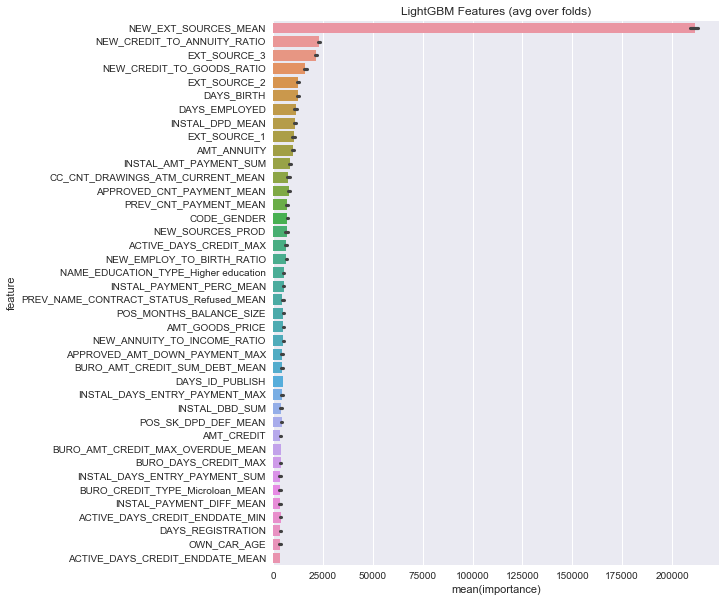

In [23]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout
plt.savefig('lgbm_importances01.png')
plt.show()

In [24]:
feature_importance_df.to_csv('feature_importance_df3.csv', index=False)

In [37]:
df=pd.read_csv('df_select_feature.csv')

In [38]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X=train_df[feats].iloc[train_idx]
y=train_df['TARGET'].iloc[train_idx]

In [40]:
warnings.filterwarnings("ignore")
import lightgbm as lgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score

In [ ]:
def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=5, random_seed=6, n_estimators=10000, learning_rate=0.02, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X, label=y, free_raw_data=False, silent=True)
    # parameters
    def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight, scale_pos_weight):
        params = {'application':'binary','boosting_type': 'gbdt','nthread': 4, 'verbose': -1,\
                  'num_iterations': n_estimators, 'learning_rate':learning_rate, 'early_stopping_round':200, 'metric':'auc'}
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        params['scale_pos_weight']= scale_pos_weight
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        return max(cv_result['auc-mean'])
    # range 
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (20, 45),
                                            'feature_fraction': (0.1, 0.95),
                                            'bagging_fraction': (0.8, 1),
                                            'max_depth': (5, 9),
                                            'lambda_l1': (0, 1),
                                            'lambda_l2': (0, 1),
                                            'min_split_gain': (0.001, 0.1),
                                            'min_child_weight': (5, 70),
                                           'scale_pos_weight':(1,10)})
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # output optimization process
    if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
    # return best parameters
    return lgbBO.res['max']['max_params']

opt_params = bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=5, random_seed=6, n_estimators=10000, learning_rate=0.02)

Initialization
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   feature_fraction |   lambda_l1 |   lambda_l2 |   max_depth |   min_child_weight |   min_split_gain |   num_leaves |   scale_pos_weight | 
